# Model Inversion & Stealing

In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

Change the dataset and split layer values as desired. Dataset can be one of `mnist`, `f_mnist`, or `cifar` while the split depth is between 1 and 6 for MNIST datasets, and 1 and 8 for the CIFAR dataset.

In [2]:
split_layer = 2

In [4]:
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

The next part trains the client and server models. You can skip this step and launch the attack directly as well.

In [9]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')


Epoch: 0 Loss: 0.3113645017147064 Acc: 96.50845608292417
Epoch: 1 Loss: 0.09283217042684555 Acc: 98.45559845559846
Epoch: 2 Loss: 0.06399916112422943 Acc: 98.35796387520526
Epoch: 3 Loss: 0.05008277669548988 Acc: 98.79518072289157
Epoch: 4 Loss: 0.042816340923309326 Acc: 98.30043859649123
Epoch: 5 Loss: 0.03488321602344513 Acc: 98.69565217391305
Epoch: 6 Loss: 0.030295055359601974 Acc: 98.84805266044981
Epoch: 7 Loss: 0.02555556409060955 Acc: 98.7885462555066
Epoch: 8 Loss: 0.02300819382071495 Acc: 98.97074756229686
Epoch: 9 Loss: 0.01938132755458355 Acc: 98.83849557522124


We are now ready to launch the attack. The next code cell loads `COUNT` many examples from each class of the dataset. Those examples will be used as targets in the attack.

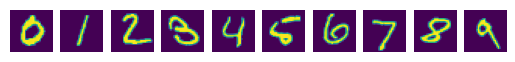

In [6]:
COUNT = 1

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28)

We now launch the attack, iterating over the examples from the previous cell.

You can change the `main_iters`, `input_iters`, and `model_iters` variables to observe how the attack performs under different configurations.

**MY COMMENT**

before training

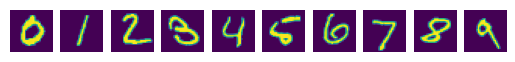

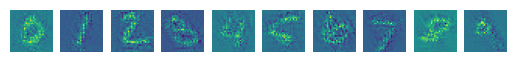

In [8]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

**MY COMMENT**

after the training

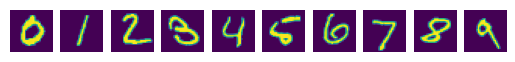

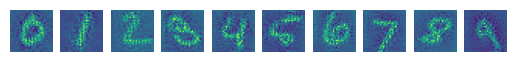

In [10]:
results, losses = [], []
for idx, target in enumerate(targetloader):
    # obtain client output
    client_out = client(target, end=split_layer)

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)